In [51]:
import itertools
import os
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook

# Define constants
person_count = 5
max_frames = 280


In [45]:
csv_dir = "dataset/csvs"

csv_files = os.listdir(csv_dir)

train_files, test_files = train_test_split(csv_files, train_size=0.8)

In [56]:
def prepare_data(file_names, limit=0):
    x = []
    y = []
    if limit != 0:
        file_names = file_names[:limit]
        
    for file_name in tqdm_notebook(file_names):

        csv = pd.read_csv(csv_dir + "/" + file_name)

        current_frame = 0

        violent = 0
        
        if len(csv) > 0:
            violent = csv.violent[0]

            csv = csv.drop('violent',axis=1)

            labels = csv.columns.values

            for label in labels[2:]:
                minmax_scale = preprocessing.MinMaxScaler().fit(csv[[label]])
                csv[[label]] = minmax_scale.transform(csv[[label]])

            data = csv.to_numpy()

            val_cumulative = {}
            frame_ids = set()
            for person in data:
                frame_ids.add(person[0])
                frame, person_id = person[:2]

                vel_array = []
                for vel in range(5, 70, 4):
                    vel_array.append(vel)

                total_vel = sum(vel_array)

                if person_id in val_cumulative:
                    val_cumulative[person_id] += total_vel
                else:
                    val_cumulative[person_id] = 0


            val_cumulative = {k: v for k, v in sorted(val_cumulative.items(), key=lambda item: item[1], reverse=True)}
            top_people = dict(itertools.islice(val_cumulative.items(), person_count))
            top_people_dataset = {}

            starter_map = {}
            for key in top_people.keys():
                starter_map[key] = np.zeros(68)

            for frame_id in frame_ids:
                # Trim to 280 if above
                if current_frame == max_frames:
                    break
                tmp_map = starter_map
                people = np.array([item for item in data if item[0] == frame_id and item[1] in top_people.keys()])
                for person in people:
                    tmp_map[person[1]] = person[2:]

                padded = list(tmp_map.values())

                for i in range(len(padded), person_count):
                    padded.append(np.zeros(68))

                top_people_dataset[frame_id] = np.asarray(padded)
                current_frame += 1


        # Pad to 280 frames if below
        for i in range(current_frame+1, max_frames+1):
            top_people_dataset[i] = []
            for j in range(0, person_count):
                top_people_dataset[i].append(np.zeros(68))

        tmp = np.asarray(list(top_people_dataset.values()))

        for entry in tmp:
            x.append(entry)

        if violent == 0:
            for entry in np.zeros(len(tmp)):
                y.append(entry)
        else:
            for entry in np.ones(len(tmp)):
                y.append(entry)
        
    return (np.asarray(list(x)), np.asarray(list(y)))

In [57]:
x_train, y_train = prepare_data(train_files, 100)

C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [17]:
x_train.shape

(28000, 5, 68)

In [18]:
y_train.shape

(28000,)

In [20]:
model = Sequential()
model.add(TimeDistributed(Flatten(input_shape=(5, 68))))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.build(input_shape=(280, 5, 68))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  67600     
_________________________________________________________________
dense_1 (Dense)              multiple                  101       
Total params: 67,701
Trainable params: 67,701
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_split=0.2)

Train on 22400 samples, validate on 5600 samples
Epoch 1/20
22400/22400 [==============================] - 2s 103us/sample - loss: 0.6059 - acc: 0.6153 - val_loss: 0.6557 - val_acc: 0.6396
Epoch 2/20
22400/22400 [==============================] - 2s 80us/sample - loss: 0.5211 - acc: 0.6699 - val_loss: 0.7033 - val_acc: 0.5634
Epoch 3/20
22400/22400 [==============================] - 2s 86us/sample - loss: 0.4756 - acc: 0.6965 - val_loss: 0.7447 - val_acc: 0.5861
Epoch 4/20
22400/22400 [==============================] - 2s 89us/sample - loss: 0.4393 - acc: 0.7101 - val_loss: 0.7938 - val_acc: 0.5700
Epoch 5/20
22400/22400 [==============================] - 2s 95us/sample - loss: 0.4209 - acc: 0.7178 - val_loss: 0.8759 - val_acc: 0.5689
Epoch 6/20
22400/22400 [==============================] - 2s 107us/sample - loss: 0.4140 - acc: 0.7221 - val_loss: 0.8071 - val_acc: 0.5782
Epoch 7/20
22400/22400 [==============================] - 2s 103us/sample - loss: 0.4058 - acc: 0.7242 - val_loss: 

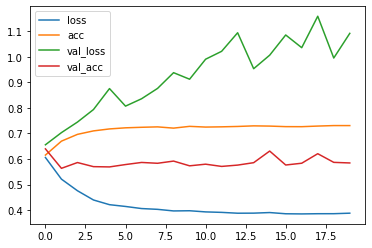

In [22]:
pd.DataFrame(history.history).plot()

In [24]:
x_test, y_test = prepare_data(test_files, 100)

NV_97_json.csv
NV_938_json.csv
V_298_json.csv
V_493_json.csv
NV_310_json.csv
NV_708_json.csv
NV_935_json.csv
V_247_json.csv
V_498_json.csv
V_228_json.csv
V_793_json.csv
V_30_json.csv
NV_377_json.csv
NV_506_json.csv
V_760_json.csv
NV_594_json.csv
V_355_json.csv
V_385_json.csv
NV_159_json.csv
V_617_json.csv
V_856_json.csv
NV_196_json.csv
NV_974_json.csv
NV_557_json.csv
V_192_json.csv
V_370_json.csv
NV_66_json.csv
V_918_json.csv
NV_859_json.csv
NV_967_json.csv
NV_45_json.csv
V_650_json.csv
V_531_json.csv
V_624_json.csv
V_464_json.csv
V_790_json.csv
NV_922_json.csv
NV_755_json.csv
NV_678_json.csv
V_728_json.csv
NV_753_json.csv
V_864_json.csv
V_45_json.csv
V_269_json.csv
V_477_json.csv
NV_400_json.csv
NV_813_json.csv
NV_448_json.csv
NV_297_json.csv
NV_79_json.csv
NV_820_json.csv
V_489_json.csv
NV_924_json.csv
NV_19_json.csv
NV_325_json.csv
NV_413_json.csv
NV_453_json.csv
V_212_json.csv
V_532_json.csv
NV_638_json.csv
V_539_json.csv
NV_735_json.csv
NV_212_json.csv
NV_846_json.csv
NV_809_json.

In [25]:
x_test.shape

(28000, 5, 68)

In [26]:
y_test.shape

(28000,)

In [27]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores

28000/28000 [==============================] - 2s 57us/sample - loss: 1.1589 - acc: 0.5679


[1.1588834816496816, 0.56792855]